<a href="https://colab.research.google.com/github/Ryan-Siglag/NBA-Back-To-Back-Analysis/blob/main/NBA_B2B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Database set up**

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("/content/database_24_25.csv") #dataframe
df.head(10)
#Note: these are individual games

,Player,Tm,Opp,Res,MP,FG,FGA,FG%,3P,3PA,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,GmSc,Data
0,Jayson Tatum,BOS,NYK,W,30.30,14,18,0.778,8,11,...,4,4,10,1,1,1,1,37,38.1,2024-10-22
1,Anthony Davis,LAL,MIN,W,37.58,11,23,0.478,1,3,...,13,16,4,1,3,1,1,36,34.0,2024-10-22
2,Derrick White,BOS,NYK,W,26.63,8,13,0.615,6,10,...,3,3,4,1,0,0,1,24,22.4,2024-10-22
3,Jrue Holiday,BOS,NYK,W,30.52,7,9,0.778,4,6,...,2,4,4,1,0,0,2,18,19.5,2024-10-22
4,Miles McBride,NYK,BOS,L,25.85,8,10,0.800,4,5,...,0,0,2,0,0,1,1,22,17.8,2024-10-22
5,Rui Hachimura,LAL,MIN,W,35.08,7,14,0.500,1,4,...,2,5,1,2,1,0,2,18,15.9,2024-10-22
6,Jaylen Brown,BOS,NYK,W,29.90,7,18,0.389,5,9,...,5,7,1,1,0,1,3,23,15.6,2024-10-22
7,Rudy Gobert,MIN,LAL,L,35.33,5,8,0.625,0,0,...,11,14,2,0,1,1,4,13,13.9,2024-10-22
8,Julius Randle,MIN,LAL,L,34.32,5,10,0.500,1,3,...,6,9,4,0,0,2,3,16,13.7,2024-10-22
9,Al Horford,BOS,NYK,W,26.08,4,7,0.571,3,5,...,3,3,5,1,1,0,2,11,13.0,2024-10-22


**Calculate Effeciency Metrics**

In [2]:
df['SG_EFF'] = df['PTS'] + df['TRB'] + df['AST'] + df ['STL'] + df['BLK'] - (df['FGA'] - df['FG']) - (df['FTA'] - df['FT']) - df['TOV']

In [3]:
df['SG_TS%'] = df['PTS'] / (2 * (df['FGA'] + 0.44*df['FTA']))

In [4]:
df['SG_EFG%'] = (df['FG'] + 1.5*df['3P']) / df['FGA']

In [5]:
df[['Player', 'SG_EFF', 'SG_TS%']].head(10)

,Player,SG_EFF,SG_TS%
0,Jayson Tatum,47,0.979873
1,Anthony Davis,45,0.608108
2,Derrick White,27,0.864553
3,Jrue Holiday,25,1.000000
4,Miles McBride,20,0.971731
5,Rui Hachimura,19,0.571066
6,Jaylen Brown,20,0.581984
7,Rudy Gobert,25,0.665984
8,Julius Randle,20,0.611621
9,Al Horford,18,0.785714


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16512 entries, 0 to 16511
Data columns (total 28 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Player   16512 non-null  object 
 1   Tm       16512 non-null  object 
 2   Opp      16512 non-null  object 
 3   Res      16512 non-null  object 
 4   MP       16512 non-null  float64
 5   FG       16512 non-null  int64  
 6   FGA      16512 non-null  int64  
 7   FG%      16512 non-null  float64
 8   3P       16512 non-null  int64  
 9   3PA      16512 non-null  int64  
 10  3P%      16512 non-null  float64
 11  FT       16512 non-null  int64  
 12  FTA      16512 non-null  int64  
 13  FT%      16512 non-null  float64
 14  ORB      16512 non-null  int64  
 15  DRB      16512 non-null  int64  
 16  TRB      16512 non-null  int64  
 17  AST      16512 non-null  int64  
 18  STL      16512 non-null  int64  
 19  BLK      16512 non-null  int64  
 20  TOV      16512 non-null  int64  
 21  PF       165

**Filter back-to-backs**

In [7]:
df['Data'] = pd.to_datetime(df['Data'], errors='coerce')

# --- Find back-to-backs at the team level ---
team_dates = (
    df[['Tm', 'Data']]
    .drop_duplicates()
    .sort_values(by=['Tm', 'Data'])
)

team_dates['days_since_last'] = team_dates.groupby('Tm')['Data'].diff().dt.days
team_dates['is_b2b_second'] = team_dates['days_since_last'] == 1

# Extract just the (Tm, Data) combos that are B2B second games
b2b_second_dates = team_dates.loc[team_dates['is_b2b_second'], ['Tm', 'Data']]

# --- Join back to player-level data ---
b2b_second_df = df.merge(b2b_second_dates, on=['Tm', 'Data'], how='inner')


In [8]:
# --- Display info ---
print(f"Original shape: {df.shape}")
print(f"Back-to-back second games shape: {b2b_second_df.shape}\n")

print("--- DataFrame Info ---")
print(b2b_second_df.info())

Original shape: (16512, 28)
Back-to-back second games shape: (2874, 28)

--- DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2874 entries, 0 to 2873
Data columns (total 28 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Player   2874 non-null   object        
 1   Tm       2874 non-null   object        
 2   Opp      2874 non-null   object        
 3   Res      2874 non-null   object        
 4   MP       2874 non-null   float64       
 5   FG       2874 non-null   int64         
 6   FGA      2874 non-null   int64         
 7   FG%      2874 non-null   float64       
 8   3P       2874 non-null   int64         
 9   3PA      2874 non-null   int64         
 10  3P%      2874 non-null   float64       
 11  FT       2874 non-null   int64         
 12  FTA      2874 non-null   int64         
 13  FT%      2874 non-null   float64       
 14  ORB      2874 non-null   int64         
 15  DRB      2874 non-null   in

**Compute player averages**

In [9]:
# --- Compute per-player averages ---
player_stats_b2b = (
    b2b_second_df.groupby('Player', as_index=False)
    .agg({
        'PTS': 'mean',   # Points per game
        'AST': 'mean',   # Assists per game
        'TRB': 'mean',   # Total rebounds per game
        'STL': 'mean',   # Steals per game
        'BLK': 'mean',   # Blocks per game
        'TOV': 'mean',   # Turnovers per game
        'MP': 'mean',    # Minutes per game
        'FG%': 'mean',
        '3P%': 'mean',
        'SG_EFF' : 'mean',
        'SG_TS%' : 'mean',
        'SG_EFG%' : 'mean',
        # 'GmSc': 'mean'   # Game Score
    })
    .rename(columns={
        'PTS': 'PPG',
        'AST': 'APG',
        'TRB': 'RPG',
        'STL': 'SPG',
        'BLK': 'BPG',
        'TOV': 'TOPG',
        'MP': 'MPG',
        'FG%': 'FG%',
        '3P%': '3P%',
        'SG_EFF': 'EFF',
        'SG_TS%' : 'TS%',
        'SG_EFG%' : 'EFG%',

        # 'GmSc': 'GameScore'
    })
)

# Round for readability
player_stats_b2b = player_stats_b2b.round(2)

# --- Optional: sort by points or minutes ---
player_stats_b2b = player_stats_b2b.sort_values(by='PPG', ascending=False)

# --- Display summary ---
print(f"Number of players with B2B second game data: {len(player_stats_b2b)}")
print(player_stats_b2b.head(10))

# --- (Optional) save ---
# player_stats_b2b.to_csv("player_b2b_second_game_averages.csv", index=False)


Number of players with B2B second game data: 526
                      Player    PPG    APG    RPG   SPG   BPG  TOPG    MPG  \
170    Giannis Antetokounmpo  34.43   5.00  11.57  0.57  1.00  4.14  35.47   
388             Nikola Jokić  34.33  10.56  11.56  1.56  0.56  3.00  35.54   
451  Shai Gilgeous-Alexander  32.12   7.00   5.00  1.88  1.50  2.00  35.94   
290       Karl-Anthony Towns  31.71   3.57  14.29  1.14  0.71  3.29  37.98   
338              Luka Dončić  31.33  12.00   7.33  2.00  0.00  2.67  39.59   
324             Kyrie Irving  31.17   4.50   3.67  0.83  0.17  2.17  39.07   
29           Anthony Edwards  31.00   5.12   5.62  1.62  0.88  3.25  37.06   
210            Jalen Brunson  30.57   8.00   2.43  0.86  0.14  1.71  36.22   
326              LaMelo Ball  29.75   8.00   4.50  2.00  0.00  5.00  34.78   
227             Jared McCain  29.00   6.50   4.50  1.00  0.00  3.50  38.40   

      FG%   3P%    EFF   TS%  EFG%  
170  0.60  0.12  34.86  0.62  0.62  
388  0.60  0.48  4

In [10]:
# Make sure 'Data' is parsed as datetime if not already
df['Data'] = pd.to_datetime(df['Data'], errors='coerce')

# --- Compute per-player averages for all games ---
player_stats_all = (
    df.groupby('Player', as_index=False)
    .agg({
        'PTS': 'mean',
        'AST': 'mean',
        'TRB': 'mean',
        'STL': 'mean',
        'BLK': 'mean',
        'TOV': 'mean',
        'MP': 'mean',
        'FG%': 'mean',
        '3P%': 'mean',
        'SG_EFF' : 'mean',
        'SG_TS%' : 'mean',
        'SG_EFG%' : 'mean',
    })
    .rename(columns={
        'PTS': 'PPG',
        'AST': 'APG',
        'TRB': 'RPG',
        'STL': 'SPG',
        'BLK': 'BPG',
        'TOV': 'TOPG',
        'MP': 'MPG',
        'FG%': 'FG%',
        '3P%': '3P%',
        'SG_EFF': 'EFF',
        'SG_TS%' : 'TS%',
        'SG_EFG%' : 'EFG%',
    })
)

# Round for readability
player_stats_all = player_stats_all.round(2)

# Sort by points for a quick view
player_stats_all = player_stats_all.sort_values(by='PPG', ascending=False)

# --- Display summary ---
print(f"Number of players in full dataset: {len(player_stats_all)}")
print(player_stats_all.head(10))

# --- (Optional) Save ---
#player_stats_all.to_csv("player_all_game_averages.csv", index=False)


Number of players in full dataset: 562
                      Player    PPG    APG    RPG   SPG   BPG  TOPG    MPG  \
480  Shai Gilgeous-Alexander  32.44   5.90   5.22  1.94  1.00  2.68  34.07   
183    Giannis Antetokounmpo  31.62   5.98  12.33  0.79  1.36  3.45  34.95   
414             Nikola Jokić  29.70  10.33  12.70  1.83  0.67  3.09  36.23   
364              Luka Dončić  28.14   7.82   8.32  2.00  0.41  3.41  35.66   
351              LaMelo Ball  28.03   7.38   5.22  1.34  0.31  3.69  33.36   
535             Tyrese Maxey  27.84   6.20   3.43  1.93  0.39  2.48  38.03   
31           Anthony Edwards  27.22   4.53   5.78  1.14  0.69  3.45  36.73   
330             Kevin Durant  26.92   4.18   6.08  0.82  1.33  3.03  36.16   
250        Jaren Jackson Jr.  26.56   2.94   6.39  1.00  1.44  2.33  32.11   
263             Jayson Tatum  26.55   5.65   8.65  1.22  0.53  2.86  36.32   

      FG%   3P%    EFF   TS%  EFG%  
480  0.53  0.37  32.86  0.65  0.67  
183  0.61  0.07  35.86  0.62

**Compare regular and back to back averages**

In [11]:
# Merge both DataFrames
comparison = pd.merge(
    player_stats_all,
    player_stats_b2b,
    on='Player',
    how='inner',
    suffixes=('_All', '_B2B')
)

# --- Compute diffs only for common stats ---
player_stats = ['PPG', 'APG', 'RPG', 'SPG', 'BPG', 'TOPG', 'MPG', 'FG%', '3P%', 'EFF', 'TS%', 'EFG%']
for stat in player_stats:
    if f'{stat}_All' in comparison.columns and f'{stat}_B2B' in comparison.columns:
        comparison[f'{stat}_Diff'] = comparison[f'{stat}_B2B'] - comparison[f'{stat}_All']

# Round & sort
comparison = comparison.round(2)
comparison = comparison.sort_values(by='PPG_Diff')

**Filter out starters & compare their regular and b2b performances**

In [12]:
starters = player_stats_all[player_stats_all['MPG'] > 24]

starter_comp = pd.merge(
    starters,
    player_stats_b2b,
    on='Player',
    how='inner',
    suffixes=('_All', '_B2B')
)

# stats = ['PPG', 'APG', 'RPG', 'SPG', 'BPG', 'TOPG', 'MPG', 'EFF', 'TS%']
for stat in player_stats:
    if f'{stat}_All' in starter_comp.columns and f'{stat}_B2B' in starter_comp.columns:
        starter_comp[f'{stat}_Diff'] = starter_comp[f'{stat}_B2B'] - starter_comp[f'{stat}_All']

starter_comp = starter_comp.round(2)


In [13]:
starter_comp = starter_comp.sort_values(by='MPG_Diff')
print(starter_comp[['Player', 'MPG_All', 'MPG_B2B', 'MPG_Diff']].head(10))

               Player  MPG_All  MPG_B2B  MPG_Diff
164  Jaime Jaquez Jr.    25.21    20.46     -4.75
58      Jalen Johnson    35.67    30.96     -4.71
121     Rui Hachimura    32.04    28.16     -3.88
201       Ben Simmons    24.99    21.40     -3.59
118   Malcolm Brogdon    24.13    20.58     -3.55
180      Caleb Martin    30.42    26.95     -3.47
176     Royce O'Neale    25.36    21.94     -3.42
98      Deandre Ayton    30.39    26.99     -3.40
186     Dereck Lively    24.14    21.19     -2.95
25      Norman Powell    33.25    30.34     -2.91


In [14]:
starter_comp = starter_comp.sort_values(by='MPG_Diff', ascending=False)
print(starter_comp[['Player', 'MPG_All', 'MPG_B2B', 'MPG_Diff']].head(10))

                 Player  MPG_All  MPG_B2B  MPG_Diff
93         Jared McCain    25.73    38.40     12.67
174          Gary Trent    24.76    32.69      7.93
92        Mark Williams    25.01    31.88      6.87
87          Jalen Suggs    28.64    34.42      5.78
94        Chet Holmgren    26.07    31.32      5.25
161   Spencer Dinwiddie    25.07    30.14      5.07
147  Guerschon Yabusele    26.84    31.02      4.18
80     Jonathan Kuminga    26.00    30.11      4.11
38           RJ Barrett    33.28    37.30      4.02
105   Immanuel Quickley    25.95    29.88      3.93


In [15]:
print(starter_comp['MPG_Diff'].mean())

0.250049504950495


In [16]:
starter_comp = starter_comp.sort_values(by='PPG_Diff', ascending=False)
starter_comp[['Player', 'PPG_All', 'PPG_B2B', 'PPG_Diff']].head(10)

,Player,PPG_All,PPG_B2B,PPG_Diff
93,Jared McCain,15.30,29.00,13.70
23,Karl-Anthony Towns,24.33,31.71,7.38
22,Kyrie Irving,24.37,31.17,6.80
161,Spencer Dinwiddie,10.30,17.00,6.70
110,Payton Pritchard,13.86,19.88,6.02
189,Max Strus,8.50,13.40,4.90
2,Nikola Jokić,29.70,34.33,4.63
11,Jalen Brunson,26.08,30.57,4.49
92,Mark Williams,15.57,20.00,4.43
81,Jordan Clarkson,16.63,21.00,4.37


In [34]:
starter_comp = starter_comp.sort_values(by='PPG_Diff')
starter_comp[['Player', 'PPG_All', 'PPG_B2B', 'PPG_Diff']].head(10)

,Player,PPG_All,PPG_B2B,PPG_Diff
43,Jordan Poole,20.84,12.29,-8.55
29,Trae Young,23.25,16.00,-7.25
194,Al Horford,7.85,1.00,-6.85
12,Anthony Davis,25.74,19.17,-6.57
13,Trey Murphy III,25.62,20.00,-5.62
21,Victor Wembanyama,24.42,19.25,-5.17
131,Tim Hardaway Jr.,12.16,7.00,-5.16
198,Wendell Carter,7.33,2.33,-5.00
18,Cam Thomas,24.68,20.20,-4.48
106,Josh Hart,14.30,9.86,-4.44


In [32]:
print("Mean change in PPG in B2Bs: " + str(starter_comp['PPG_Diff'].mean().round(3)))

Mean change in PPG in B2Bs: -0.131


In [33]:
t_statistic, p_value = stats.ttest_ind(starter_comp['PPG_All'], starter_comp['PPG_B2B'])
print(f"P-value: {p_value}")


P-value: 0.8342197578667354


**Compare Efficency**

In [19]:
print("Average Starter FG Over All Games: " + str(starter_comp['FG%_All'].mean()))
print("Average Starter FG Over B2B's: " + str(starter_comp['FG%_B2B'].mean()))

t_statistic, p_value = stats.ttest_ind(starter_comp['FG%_All'], starter_comp['FG%_B2B'])
print(f"P-value: {p_value}")

Average Starter FG Over All Games: 0.46282178217821784
Average Starter FG Over B2B's: 0.4524257425742575
P-value: 0.1929934356358778


In [20]:
print("Average Starter FG Over All Games: " + str(starter_comp['3P%_All'].mean()))
print("Average Starter FG Over B2B's: " + str(starter_comp['3P%_B2B'].mean()))

t_statistic, p_value = stats.ttest_ind(starter_comp['3P%_All'], starter_comp['3P%_B2B'])
print(f"P-value: {p_value}")

Average Starter FG Over All Games: 0.3166831683168317
Average Starter FG Over B2B's: 0.3054950495049505
P-value: 0.34538543573686764


In [21]:
print("Average Starter Efficiency Over All Games: " + str(starter_comp['EFF_All'].mean()))
# print("EFF Standard Deviation  " + str(starter_comp['EFF_All'].std()))
print("Average Starter Efficiency Over B2B's: " + str(starter_comp['EFF_B2B'].mean()))
t_statistic, p_value = stats.ttest_ind(starter_comp['EFF_All'], starter_comp['EFF_B2B'])
# print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")

Average Starter Efficiency Over All Games: 17.44450495049505
Average Starter Efficiency Over B2B's: 16.964554455445544
P-value: 0.45942098493278494


In [22]:
print("Average Starter TS Over All Games: " + str(starter_comp['TS%_All'].mean()))
print("Average Starter TS Over B2B's: " + str(starter_comp['TS%_B2B'].mean()))

t_statistic, p_value = stats.ttest_ind(starter_comp['TS%_All'], starter_comp['TS%_B2B'])
print(f"P-value: {p_value}")

Average Starter TS Over All Games: 0.571980198019802
Average Starter TS Over B2B's: 0.5564851485148514
P-value: 0.047516487451232305


In [23]:
print(starter_comp[['Player', 'TS%_All', 'TS%_B2B', 'TS%_Diff']])

                 Player  TS%_All  TS%_B2B  TS%_Diff
43         Jordan Poole     0.56     0.49     -0.07
29           Trae Young     0.55     0.46     -0.09
194          Al Horford     0.52     0.10     -0.42
12        Anthony Davis     0.58     0.59      0.01
13      Trey Murphy III     0.66     0.48     -0.18
..                  ...      ...      ...       ...
110    Payton Pritchard     0.61     0.73      0.12
161   Spencer Dinwiddie     0.54     0.66      0.12
22         Kyrie Irving     0.60     0.64      0.04
23   Karl-Anthony Towns     0.63     0.67      0.04
93         Jared McCain     0.58     0.63      0.05

[202 rows x 4 columns]


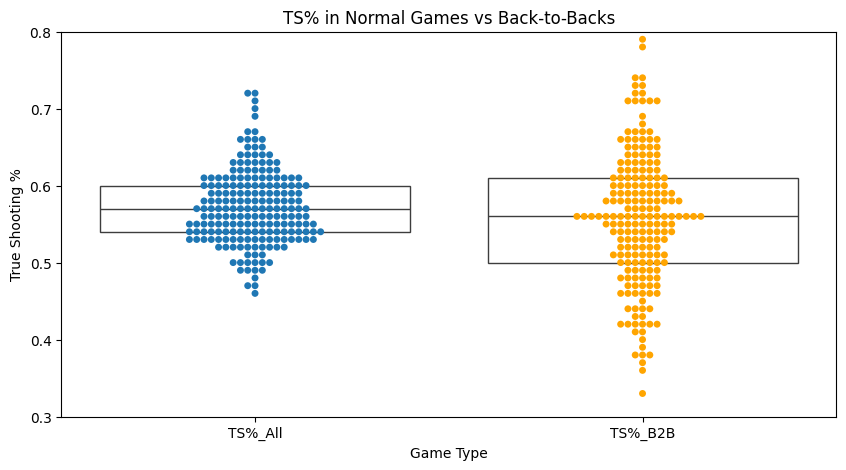

In [24]:
ts_comp = starter_comp.melt(
    id_vars=["Player"],
    value_vars=["TS%_All", "TS%_B2B"],
    var_name="Game_Type",
    value_name="ts"
)

plt.figure(figsize=(10,5))
plt.ylim(0.30, 0.80)

sns.swarmplot(
    data=ts_comp,
    x="Game_Type",
    y="ts",
    hue = 'Game_Type',
    palette={"TS%_All": "C0", "TS%_B2B": "orange"},
    legend=False,
)

sns.boxplot(
    data=ts_comp,
    x="Game_Type",
    y="ts",
    showcaps=False,
    boxprops={'facecolor': 'none'},
    showfliers=False,
    whiskerprops={'linewidth': 0},
)

plt.xlabel("Game Type")
plt.ylabel("True Shooting %")
plt.title("TS% in Normal Games vs Back-to-Backs")
plt.show()

In [25]:
print("Average Starter EFG Over All Games: " + str(starter_comp['EFG%_All'].mean()))
# print("Standard Deviation of EFG Over All Games: " + str(starter_comp['EFG%_All'].std()))
print("Average Starter EFG Over B2B's: " + str(starter_comp['EFG%_B2B'].mean()))
# print("Average Starter EFG Diff: " + str(starter_comp['EFG%_Diff'].mean()))

t_statistic, p_value = stats.ttest_ind(starter_comp['EFG%_All'], starter_comp['EFG%_B2B'])
print(f"P-value: {p_value}")

Average Starter EFG Over All Games: 0.6856435643564357
Average Starter EFG Over B2B's: 0.6608415841584159
P-value: 0.04795386926485896


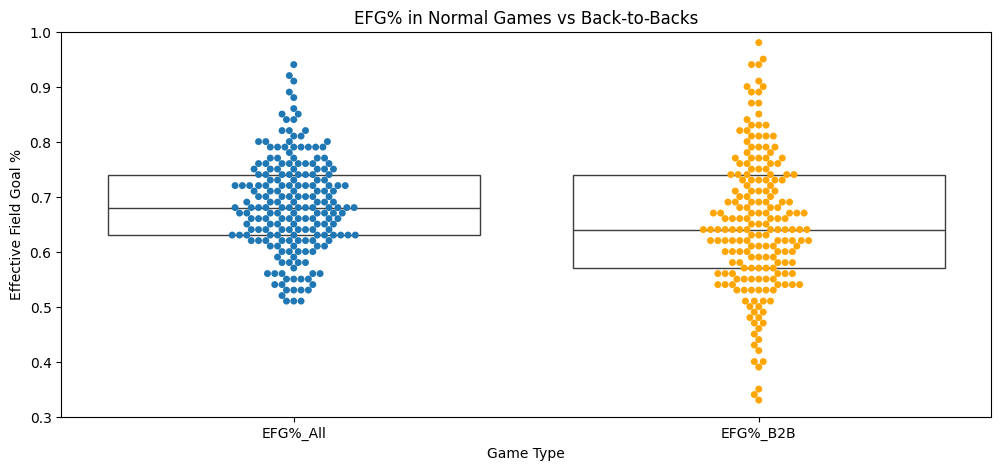

In [26]:
efg_comp = starter_comp.melt(
    id_vars=["Player"],
    value_vars=["EFG%_All", "EFG%_B2B"],
    var_name="Game_Type",
    value_name="efg"
)

plt.figure(figsize=(12,5))
plt.ylim(0.30, 1)

sns.swarmplot(
    data=efg_comp,
    x="Game_Type",
    y="efg",
    hue="Game_Type",
    palette={"EFG%_All": "C0", "EFG%_B2B": "orange"},
    legend=False,
)

sns.boxplot(
    data=efg_comp,
    x="Game_Type",
    y="efg",
    showcaps=False,
    boxprops={'facecolor': 'none'},
    showfliers=False,
    whiskerprops={'linewidth': 0},
)

plt.xlabel("Game Type")
plt.ylabel("Effective Field Goal %")
plt.title("EFG% in Normal Games vs Back-to-Backs")
plt.show()

**Group by team**

In [27]:
team_stats = (
    df.groupby('Tm', as_index=False)
    .agg({
        'PTS': 'mean',
        'AST': 'mean',
        'TRB': 'mean',
        'STL': 'mean',
        'BLK': 'mean',
        'TOV': 'mean',
        'MP': 'mean',
    })
        .rename(columns={
        'PTS': 'PPG',
        'AST': 'APG',
        'TRB': 'RPG',
        'STL': 'SPG',
        'BLK': 'BPG',
        'TOV': 'TOPG',
        'MP': 'MPG',
    })
)

team_stats = team_stats.round(2)
team_stats = team_stats.sort_values(by="MPG", ascending=False)

print(team_stats.head(5))

     Tm    PPG   APG   RPG   SPG   BPG  TOPG    MPG
0   ATL  11.76  2.95  4.58  1.03  0.52  1.54  24.47
19  NYK  11.72  2.75  4.30  0.80  0.38  1.19  23.96
17  MIN  11.08  2.52  4.36  0.79  0.50  1.44  23.91
2   BRK  10.37  2.44  4.01  0.73  0.41  1.37  23.78
18  NOP  10.83  2.48  4.22  0.92  0.54  1.33  23.73


In [28]:
team_stats_b2b = (
    b2b_second_df.groupby('Tm', as_index=False)
    .agg({
        'PTS': 'mean',
        'AST': 'mean',
        'TRB': 'mean',
        'STL': 'mean',
        'BLK': 'mean',
        'TOV': 'mean',
        'MP': 'mean',
    })
        .rename(columns={
        'PTS': 'PPG',
        'AST': 'APG',
        'TRB': 'RPG',
        'STL': 'SPG',
        'BLK': 'BPG',
        'TOV': 'TOPG',
        'MP': 'MPG',
    })
)

team_stats_b2b = team_stats_b2b.round(2)
team_stats_b2b = team_stats_b2b.sort_values(by="MPG", ascending=False)

print(team_stats_b2b.head(5))

     Tm    PPG   APG   RPG   SPG   BPG  TOPG    MPG
8   DET  11.75  2.68  4.50  0.69  0.49  1.40  24.83
19  NYK  12.43  2.93  4.35  0.74  0.28  1.29  24.71
10  HOU  10.83  2.01  4.82  0.88  0.65  1.46  24.25
2   BRK  10.18  2.30  4.18  0.77  0.26  1.43  24.24
18  NOP  10.73  2.48  4.31  1.01  0.58  1.35  24.23


**Compare Teams in regular games and b2bs**

In [29]:
tm_comp = pd.merge(
    team_stats,
    team_stats_b2b,
    on="Tm",
    how="inner",
    suffixes=('_All', '_B2B')
)

tm_comp['MPG_Diff'] = tm_comp['MPG_All'] - tm_comp['MPG_B2B']

tm_comp.sort_values(by='MPG_Diff')

print(tm_comp.head(5))

    Tm  PPG_All  APG_All  RPG_All  SPG_All  BPG_All  TOPG_All  MPG_All  \
0  ATL    11.76     2.95     4.58     1.03     0.52      1.54    24.47   
1  NYK    11.72     2.75     4.30     0.80     0.38      1.19    23.96   
2  MIN    11.08     2.52     4.36     0.79     0.50      1.44    23.91   
3  BRK    10.37     2.44     4.01     0.73     0.41      1.37    23.78   
4  NOP    10.83     2.48     4.22     0.92     0.54      1.33    23.73   

   PPG_B2B  APG_B2B  RPG_B2B  SPG_B2B  BPG_B2B  TOPG_B2B  MPG_B2B  MPG_Diff  
0    11.07     2.84     4.17     1.10     0.53      1.57    24.00      0.47  
1    12.43     2.93     4.35     0.74     0.28      1.29    24.71     -0.75  
2    10.93     2.48     4.00     0.74     0.57      1.25    22.86      1.05  
3    10.18     2.30     4.18     0.77     0.26      1.43    24.24     -0.46  
4    10.73     2.48     4.31     1.01     0.58      1.35    24.23     -0.50  


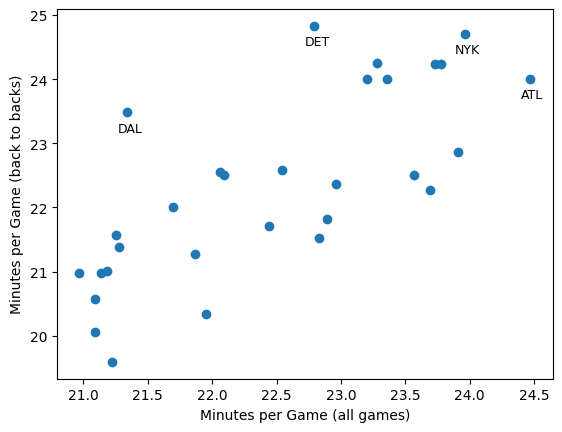

In [30]:
for _, row in tm_comp[(tm_comp['MPG_All'] > 24) | (tm_comp['MPG_B2B'] > 24.5) | ((tm_comp['MPG_All'] < 23) & (tm_comp['MPG_B2B'] > 23))].iterrows():
    plt.text(
        row['MPG_All']-0.075,
        row['MPG_B2B'] - 0.3,
        row['Tm'],
        fontsize=9,
        color='black'
    )


plt.scatter(tm_comp['MPG_All'], tm_comp['MPG_B2B'])
plt.xlabel('Minutes per Game (all games)')
plt.ylabel('Minutes per Game (back to backs)')

plt.show()